# **Ensemble Tree-Based Learning for Accurate Multiclass Dementia Classification from Clinical Data**

# ==============================================================
# Phase 0: Environment & GPU Check
# ==============================================================

In [2]:
import os
import sys
import platform
from subprocess import getoutput

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("CUDA available:", 'Yes' if getoutput('nvidia-smi').startswith('Tue') or 'NVIDIA' in getoutput('nvidia-smi') else 'No')
!nvidia-smi

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
CUDA available: Yes
Mon Jun 30 02:05:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             54W /  400W |     423MiB /  40960MiB |      0%      Default |
|     

import os
import sys
import platform
from subprocess import getoutput

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("CUDA available:", 'Yes' if getoutput('nvidia-smi').startswith('Tue') or 'NVIDIA' in getoutput('nvidia-smi') else 'No')
!nvidia-smi

In [3]:
!pip install -q kaggle shap lightgbm MultiColumnLabelEncoder

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from MultiColumnLabelEncoder import MultiColumnLabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import shap
import seaborn as sns
from matplotlib import pyplot as plt

# ==============================================================
# Phase 2: Kaggle API Dataset Loading
# ==============================================================

In [4]:
from google.colab import files
files.upload()  # Upload kaggle.json

os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
os.chmod('/root/.kaggle/kaggle.json', 0o600)
!kaggle datasets download -d shashwatwork/dementia-prediction-dataset
!unzip -o dementia-prediction-dataset.zip

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/shashwatwork/dementia-prediction-dataset
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
dementia-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dementia-prediction-dataset.zip
  inflating: dementia_dataset.csv    


# ==============================================================
# Phase 3: Data Exploration & Cleaning
# ==============================================================

In [5]:
df = pd.read_csv('dementia_dataset.csv')
print("Data shape:", df.shape)
print(df.head())

# Drop unneeded columns
df.drop(["Subject ID", "MRI ID", "Hand"], axis=1, inplace=True)

# Check for missing values
print("Nulls per column:")
print(df.isnull().sum())

Data shape: (373, 15)
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034  
Nulls per column:
Group        0
Visit        0
MR Delay     0
M/F          0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64


# ==============================================================
# Phase 4: Advanced Imputation (Median for numeric, Mode for categorical)
# ==============================================================

In [6]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns.drop('Group')

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# ==============================================================
# Phase 5: Encoding & Feature Engineering
# ==============================================================

In [7]:
X = df.drop('Group', axis=1)
y = df['Group']

# Encode categorical columns
Mcle = MultiColumnLabelEncoder()
X = Mcle.fit_transform(X)

label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

print("Encoded Classes:", label_encoder.classes_)

Encoded Classes: ['Converted' 'Demented' 'Nondemented']


# ==============================================================
# Phase 6: Train/Test Split (Stratified)
# ==============================================================

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# ==============================================================
# Phase 7: XGBoost Modeling + Stratified Cross-Validation
# ==============================================================

In [9]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
base_xgb = XGBClassifier(max_depth=2, n_estimators=50, learning_rate=0.1, subsample=0.8,
                        colsample_bytree=0.8, colsample_bylevel=0.7, eval_metric='mlogloss')
cv_scores = cross_val_score(base_xgb, X, y_enc, cv=skf)
print("StratifiedKFold Accuracy: {:.2f}% (±{:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*100))

StratifiedKFold Accuracy: 91.15% (±2.09%)



# ==============================================================
# Phase 8: Hyperparameter Tuning (GridSearchCV for XGBoost)
# ==============================================================

In [10]:
param_grid = {
    'max_depth': [2, 4, 6],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
grid = GridSearchCV(XGBClassifier(eval_metric='mlogloss'), param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X, y_enc)
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Accuracy: {:.2f}%".format(grid.best_score_*100))

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}
Best Cross-Validated Accuracy: 92.22%


# ==============================================================
# Phase 9: Model Comparison (XGBoost, RF, SVM, LightGBM)
# ==============================================================

In [11]:

models = {
    'XGBoost': XGBClassifier(**grid.best_params_, eval_metric='mlogloss'),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'LightGBM': LGBMClassifier()
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f'{name} Accuracy: {acc:.4f}')


XGBoost Accuracy: 0.8933
Random Forest Accuracy: 0.9067
SVM Accuracy: 0.5067
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 11
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

# ==============================================================
# Phase 10: SHAP Explainability for Best XGBoost Model
# ==============================================================

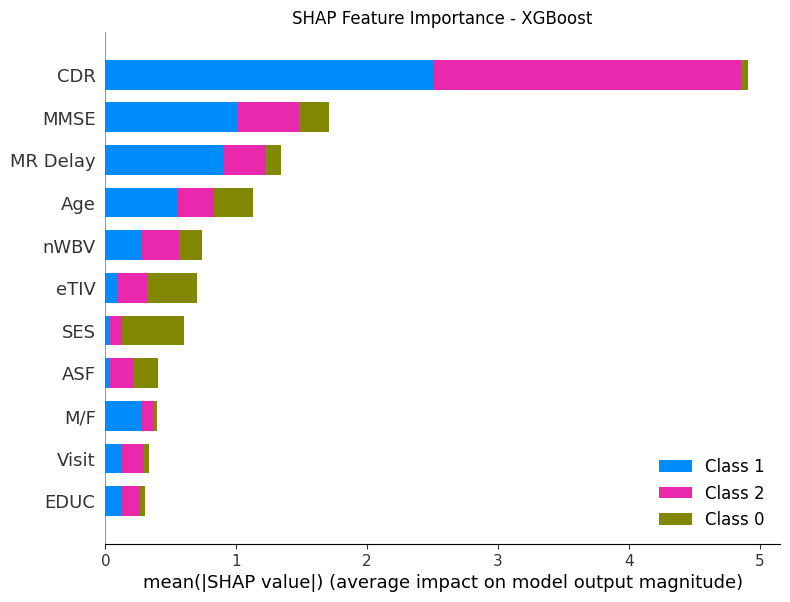

In [12]:
best_xgb = XGBClassifier(**grid.best_params_, eval_metric='mlogloss')
best_xgb.fit(X_train, y_train)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - XGBoost")
plt.show()


# ==============================================================
# Phase 11: Metrics Evaluation & Visualization
# ==============================================================

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

   Converted       0.50      0.25      0.33         8
    Demented       0.96      0.93      0.95        29
 Nondemented       0.88      1.00      0.94        38

    accuracy                           0.89        75
   macro avg       0.78      0.73      0.74        75
weighted avg       0.87      0.89      0.88        75

Model Comparison Results:
               Test Accuracy
XGBoost             0.893333
Random Forest       0.906667
SVM                 0.506667
LightGBM            0.906667


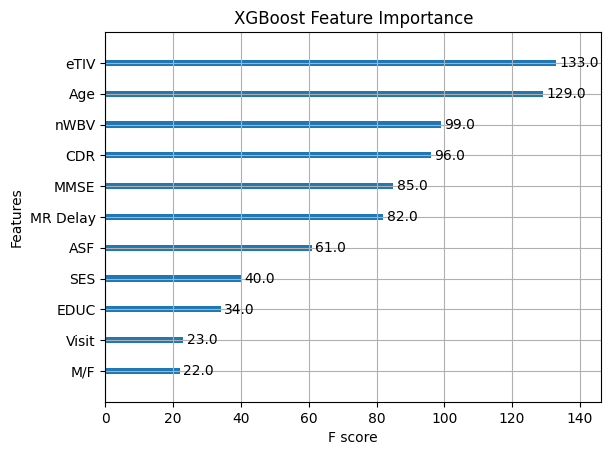

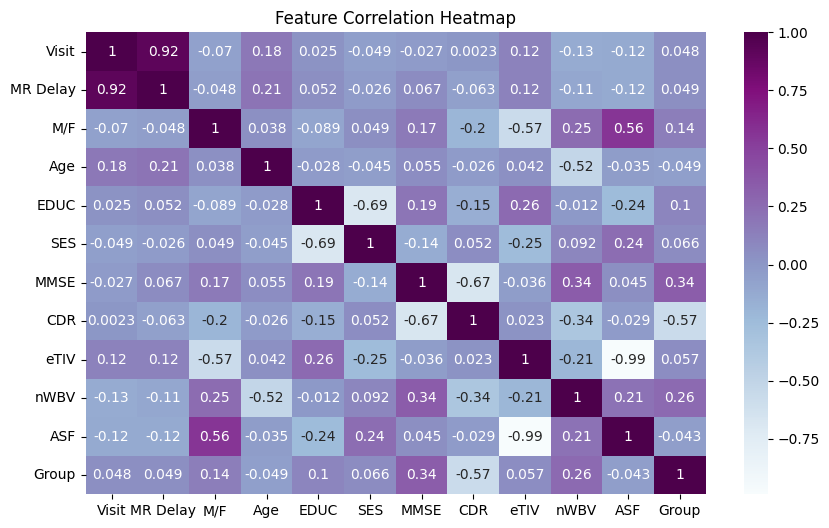

In [13]:








print("Classification Report for Best XGBoost Model:")
print(classification_report(y_test, best_xgb.predict(X_test), target_names=label_encoder.classes_))

print("Model Comparison Results:")
print(pd.DataFrame(results, index=['Test Accuracy']).T)

plot_importance(best_xgb)
plt.title("XGBoost Feature Importance")
plt.show()

corr = pd.DataFrame(X, columns=df.columns.drop('Group')).join(pd.Series(y_enc, name='Group')).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='BuPu')
plt.title("Feature Correlation Heatmap")
plt.show()


Thank You